# Media Analyser - By Gabriel Hanich

In [31]:
# Imports
import json
from collections import Counter
from datetime import date, datetime
import datetime as dt
import csv

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as corpusStopwords

from wordcloud import WordCloud, STOPWORDS

import praw

import sys
sys.path.append('../') # Allows importing of local modules

from lib.data import GetData
from lib.media import Outlet, Article

In [32]:
# 'widget' displays as interactable inline element where 'qt' opens graph in new window 
%matplotlib widget

In [33]:
# Constants
dataVersion = 2
stopwords = corpusStopwords.words("english")

In [4]:
def daterange(date1, date2): # Returns list of dates between 2 dates
    for n in range(int((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)

In [5]:
# Takes a 2D array (list of lists) and converts into one list
def flattenList(myList):
    newList = []
    for val in myList:
        if type(val) == list:
            for smallVal in val:
                newList.append(smallVal)
        else:
            newList.append(val)
    return newList

In [34]:
# Return X, Y and Z Vals for a giveb media Outlet (depending on given constants)
def getXYVals(thisOutlet, statType, startDate, endDate, titleSearchWords, commonWordCount):
    # Returns a list containing the x, y and z (annotation) for a given media outlet
    xVals = []
    yVals = []
    zVals = []
    for myDate in list(daterange(startDate, endDate)): # For every date between the given start and end date
        try:
            articleCount = 0
            avgSentiment = 0
            commonWords = []
            totalWords = []
            for articleIndex, article in enumerate(thisOutlet.dayDict[myDate.strftime("%d/%m/%Y")]):
                # If there are no title search words OR title contains wanted word
                if titleSearchWords == [] or set(flattenList(titleSearchWords)).intersection(word_tokenize(article["headline"].lower())):
                    articleCount += 1
                    avgSentiment += article["intensityScore"]
                    for word in word_tokenize(article["headline"]):
                        if len(word) > 2:
                            if word.lower() not in stopwords:
                                totalWords.append(str(word))
            # Get most common key words for the day
            commonWordsRaw = Counter(totalWords).most_common(commonWordCount)
            commonWords = []
            for word in commonWordsRaw:
                commonWords.append(list(word))
            # Append data depending on chosen chart type        
            if statType == "articleCount":
                yVals.append(articleCount)
            elif statType == "avgSentiment":
                try:
                    yVals.append(avgSentiment / articleCount)
                except ZeroDivisionError:
                    yVals.append(0)
            elif statType  == "commonWords":
                yVals.append(articleCount)
                zVals.append(commonWords)

            xVals.append(myDate)
        except KeyError: # In case outlet has no articles published on that date (Returns empty lists)
            pass
    return xVals, yVals, zVals

In [35]:
# Convert .json data to classes
with open("../media Outlets.csv") as outletsFile: # Get list of outlets
    outletsData = GetData(outletsFile)

outlets = []
for thisOutlet in outletsData:
    outlets.append(Outlet(thisOutlet[0]))

    with open("../data/" + str(dataVersion) + "/json/" + thisOutlet[0] + ".json", encoding="utf-8") as dataFile:
        outlets[-1].setDayDict(json.load(dataFile)) # Write daydict to outlet Object

In [22]:
# User settings

# Dates
doSetDates = True # Whether to use user-specified dates
startingDate = "13/9/2021"
endDate = "23/01/2022"

# Outlets
doSetOutlets = True # Whether to limit search to a set of outlets
setOutlets = [] # Only include a set of outlets
doTotalOutlets = True # Whether to take the outlets as a total

# Title searching
titleSearchWords = ["cleo", "smith", "carnarvon"] # Only include articles with headlines containing these words (Leave BLANK to disable)

# Similar Words settings
doSimilarWords = False # Whether to scan reddit for similar words to the title search words
searchPostsCount = 500 # How many posts to scan per word
searchWords = 10 # How many words from reddit are added per keyword
minOccurenceCount = 5 # Minimum amount of times a word has to appear to be registered as 'similar'

# Chart Settings
commonWordCount = 1 # How many common words per day are displayed
chartType = "articleCount" # Type of chart to make'


In [23]:
# Convert string userDates to datetime objs
startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
endDate = datetime.strptime(endDate, "%d/%m/%Y")

In [24]:
# Combine all outlets into one if doTotalOutlets == True
if doTotalOutlets:
    totalOutlet = Outlet("Total")
    thisDayDict = {}
    for date in daterange(startingDate, endDate):
        strDate = datetime.strftime(date, "%d/%m/%Y")
        thisArticleList = []
        for mediaOutlet in outlets:
            try:
                for articleIndex, article in enumerate(mediaOutlet.dayDict[strDate]):
                    thisArticleList.append(article)
            except KeyError:
                pass
        if len(thisArticleList) != 0:
            thisDayDict[strDate] = thisArticleList
    totalOutlet.setDayDict(thisDayDict)

In [25]:
# Scan reddit for similar keywords to those given by titleSearchWords
if doSimilarWords:
    print("Starting")
    similarSearchWords = []
    reddit = praw.Reddit(client_id='GRD68owJs221Qw', client_secret='K1ug6GHtgHiKxkcHBpiO3ei7yRtDWQ', user_agent='Gabriel')
    all = reddit.subreddit("all") # Create subreddit object
    for sectionIndex, section in enumerate(titleSearchWords):
        sectionKeyWords = []
        # Flatten section into single list containing all the words
        wordsList = []
        if type(section) == list: # If list contains sub-lists (i.e has multiple search words per section)
            for word in section:
                wordsList.append(word)
        else:
            wordsList.append(section)
        foundWords = []
        for searchIndex, searchWord in enumerate(wordsList):
            for post in all.search(searchWord, limit=searchPostsCount): # Search for the top (seachCount) posts about (searchWord)
                title = word_tokenize(post.title)
                for word in title:
                    word = word.lower()
                    if not word in stopwords and len(word) > 2:
                        foundWords.append(word)
            print("DONE " + str(round((sectionIndex + 1) / len(titleSearchWords), 2)) + 
              " " + str(round((searchIndex + 1)/ len(wordsList), 2)))
        for keyWord in Counter(foundWords).most_common(searchWords):
            if keyWord[1] >= minOccurenceCount:
                sectionKeyWords.append(str(keyWord[0]))
        similarSearchWords.append(sectionKeyWords)
                    
    print("FINISHED")

In [26]:
# If doSetOutlets, only include user-listed outlets
if doSetOutlets:
    setOutlets = []
    for mediaOutlet in outlets:
        if mediaOutlet.name in setOutlets:
            setOutlets.append(mediaOutlet)


In [27]:
# Save both an unmodified and modified version of titleSearchWords and outlets
if doTotalOutlets:
    plotOutlets = [totalOutlet]
elif doSetOutlets:
    plotOutlets = setOutlets
else:
    plotOutlets = outlets
if doSimilarWords:
    plotSearchWords = similarSearchWords
    print("Similar words run, searchwords = \n" + str(plotSearchWords))
else:
    plotSearchWords = titleSearchWords
    

Running
Done 1 /1


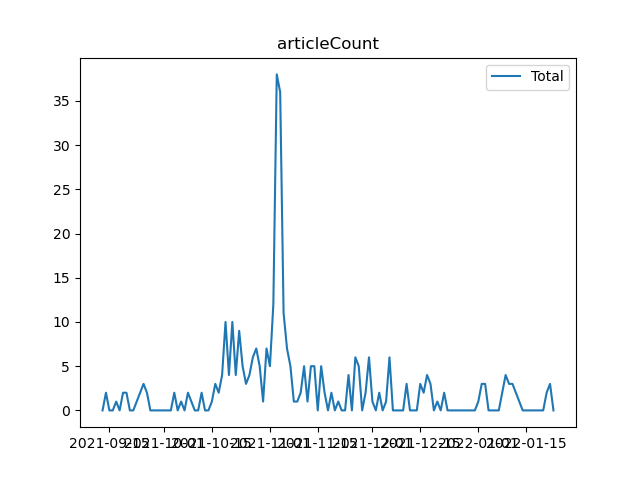

In [28]:
# Plot data 
fig, ax = plt.subplots(1)
ax.set_title(chartType)
print("Running")
for mediaIndex, mediaOutlet in enumerate(plotOutlets):
    try:
        if not doSetDates: # Auto Generate first and last dates if NOT doSetDates
            startingDate = list(mediaOutlet.dayDict.keys())[0] # Get date of first article
            endDate = list(mediaOutlet.dayDict.keys())[-1] # Get date of last article

            startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
            endDate = datetime.strptime(endDate, "%d/%m/%Y")

    except IndexError: # In case outlet has 0 articles at all
        continue
    
    doMultiCategories = False # If multiple catergories off search words is given
    if len(titleSearchWords) != 0:
        if type(titleSearchWords[0]) == list:
            doMultiCategories = True
            for searchList in titleSearchWords:
                xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, searchList, commonWordCount)
                mediaOutlet.setVals(xVals, yVals, zVals)
                ax.plot(xVals, yVals, label=mediaOutlet.name + " [" + str(searchList[0]) + "]")  

                if len(zVals) != 0: # If there are annotations present
                    for dayIndex, dayPoint in enumerate(zVals):
                        for i in range(len(dayPoint)):
                            ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
    if not doMultiCategories:
        xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, plotSearchWords, commonWordCount)
        mediaOutlet.setVals(xVals, yVals, zVals)
        ax.plot(xVals, yVals, label=mediaOutlet.name)  
        
        if len(zVals) != 0: # If there are annotations present
            for dayIndex, dayPoint in enumerate(zVals):
                for i in range(len(dayPoint)):
                    ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
    print("Done " + str(mediaIndex + 1) + " /" + str(len(plotOutlets)))
        
if chartType == "avgSentiment": # Set yLim to max and min possible sentiment scores
    plt.ylim(-1, 1)

ax.legend()

In [29]:
# Text outputs
for mediaOutlet in plotOutlets:
    print(mediaOutlet.name)
    if chartType == "articleCount" or chartType == "commonWords":
        articleCount = 0
        for val in mediaOutlet.yVals:
            articleCount += val
        print("Published " + str(articleCount) + " articles in " + str(len(mediaOutlet.xVals)) + " days")
        try:
            print("An average of ~" + str(round(articleCount / len(mediaOutlet.xVals), 2)) + " articles per day")
        except ZeroDivisionError:
            print("An average of 0 articles per day")
    elif chartType == "avgSentiment":
        largestScore, smallestScore, totalScore = -1, 1, 0
        largestIndex, smallestIndex = 0, 0
        for valIndex, val in enumerate(mediaOutlet.yVals):
            val = round(val, 2)
            totalScore += val
            if val < smallestScore:
                smallestScore = val
                smallestIndex = valIndex
            if val > largestScore:
                largestScore = val
                largestIndex = valIndex
        try:
            print("Had an average daily sentiment of ~" + 
                  str(round(totalScore / len(mediaOutlet.xVals), 2)) + " over " + 
                  str(len(mediaOutlet.xVals)) + " days") 
        except ZeroDivisionError:
            print("Had an average daily sentiment of 0")
            
        try:
            print("Most POSITIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[largestIndex], "%d/%m/%Y") + 
                  " scoring " + str(largestScore))
            print("Most NEGATIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[smallestIndex], "%d/%m/%Y") + 
                  " scoring " + str(smallestScore))
        except IndexError:
            print("NO DATA FOR MOST POSITIVE OR NEGATIVE DAYS")
    print("\n")

Total
Published 330 articles in 133 days
An average of ~2.48 articles per day




Total WORD PLOT


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

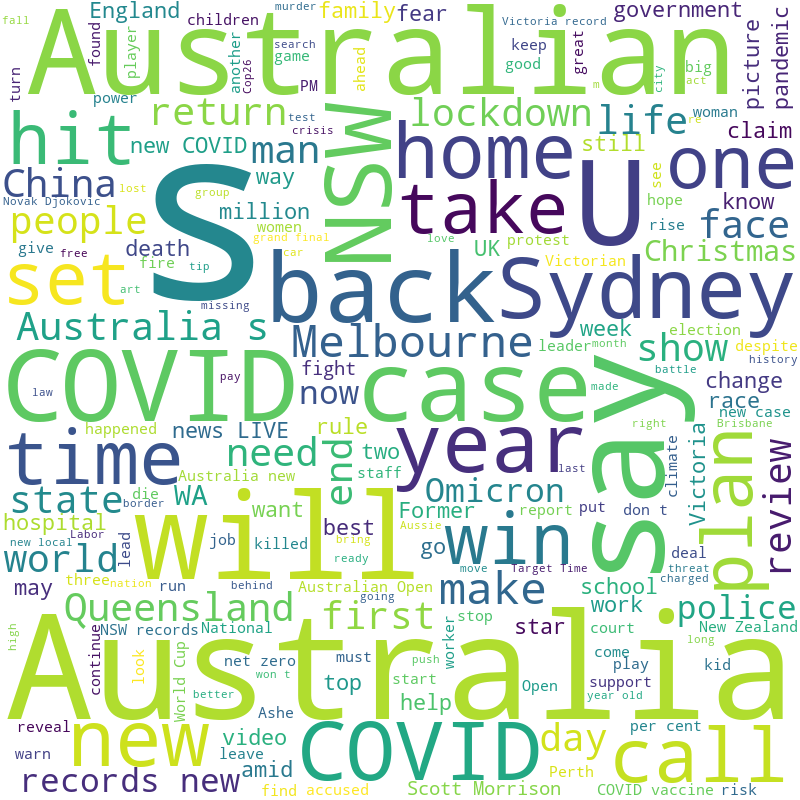

In [36]:
# Create word cloud
stopwords = set(STOPWORDS)

# Change Index below to specify outlet plotted
mediaOutlet = plotOutlets[0]

# Add all words from headlines into single string
articleString = ""
for thisDate in daterange(startingDate, endDate):
    strDate = thisDate.strftime("%d/%m/%Y")
    try:
        for article in mediaOutlet.dayDict[strDate]:
            articleString += article["headline"] + " "
    except KeyError:
        pass
    
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(articleString)

print(mediaOutlet.name + " WORD PLOT")

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


In [ ]:
# Export X, Y, Z vals as .csv file
resultsFile = open("../data/" + str(dataVersion) + "/results/" + chartType + ".csv", 
                   "w", encoding='UTF8', newline='')
csvWriter = csv.writer(resultsFile)
csvWriter.writerow(["Category: All categories"])
csvWriter.writerow([])
nameList = ["day"]
for mediaOutlet in plotOutlets:
    nameList.append(mediaOutlet.name)
    
csvWriter.writerow(nameList)
for dateIndex, myDate in enumerate(daterange(startingDate, endDate)):
    thisRow = [datetime.strftime(myDate, "%Y-%m-%d")]
    for mediaOutlet in plotOutlets:
        try:
            thisRow.append(mediaOutlet.yVals[dateIndex])
        except IndexError:
            thisRow.append(0)
    csvWriter.writerow(thisRow)
resultsFile.close()